In [173]:
using BioTools, Dates, BioSequences, TreeTools
using Plots
using StatsBase, Statistics
using JSON
include("../functions/plot_functions.jl")

pfix_v_freq_positivederivative (generic function with 1 method)

In [2]:
pyplot();

In [3]:
lfs = 22 # Legend font size
alfs = 26 # axis label font size
tfs = 22 # title font size
atfs = 22 # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
plotfolder = "Misc"

"Misc"

# Synonymous mutations
I'll look at nt mutations at all positions that have never seen an AA change. 

In [4]:
startdate = Date(2000)
binwidth = Day(30)
binspacing = Day(30);

In [5]:
nt_aln = "../../data/aligned_h3n2_ha.fasta"
fp = Flu.FluPop(nt_aln, :dna, Flu.flu_usual_header_fields, flulineage = "h3n2", segment = "ha");
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing=binspacing);

Reading ../../data/aligned_h3n2_ha.fasta...
Read 44975 strains out of 61848. Filtered 16873. Could not read 0


In [6]:
# Finding positions with 1 AA only
aa_aln = "../../data/aligned_h3n2_ha_aa.fasta"
S = readfastastrains(aa_aln, :aa, Flu.flu_usual_header_fields, 
    strainfilters = [BioTools.gapfilter, !Flu.is_flu_outlier("h3n2"), BioTools.hasdate]);
synpos = Int64[]
for (i,a) in enumerate(S[1].seq)
    f = true
    for s in S
        if isambiguous(a) && !isambiguous(s.seq[i])
            a = s.seq[i]
        end
        if s[:date] > startdate && !isambiguous(s.seq[i]) && s.seq[i] != a
            f = false
#             println("$i: $(s.seq[i]) != $a")
            break
        end
    end
    f && push!(synpos, i)
end
synpos = vcat([collect((i-1)*3 .+ (1:3)) for i in synpos]...);

Reading ../../data/aligned_h3n2_ha_aa.fasta...
Read 44976 strains out of 61848. Filtered 16872. Could not read 0


In [7]:
# Third codon positions
thirdpos = [3*i for i in 1:length(S[1].seq)];

In [8]:
ph_syn = [Flu.PosEvo(fp, i) for i in synpos];
ph_third = [Flu.PosEvo(fp, i) for i in thirdpos];

In [9]:
alphabins_ = 0.1:0.1:0.9
alphabins = [(a, 0.05) for a in alphabins_];

In [10]:
x,y,err = pfix_v_freq(ph_third, alphabins);

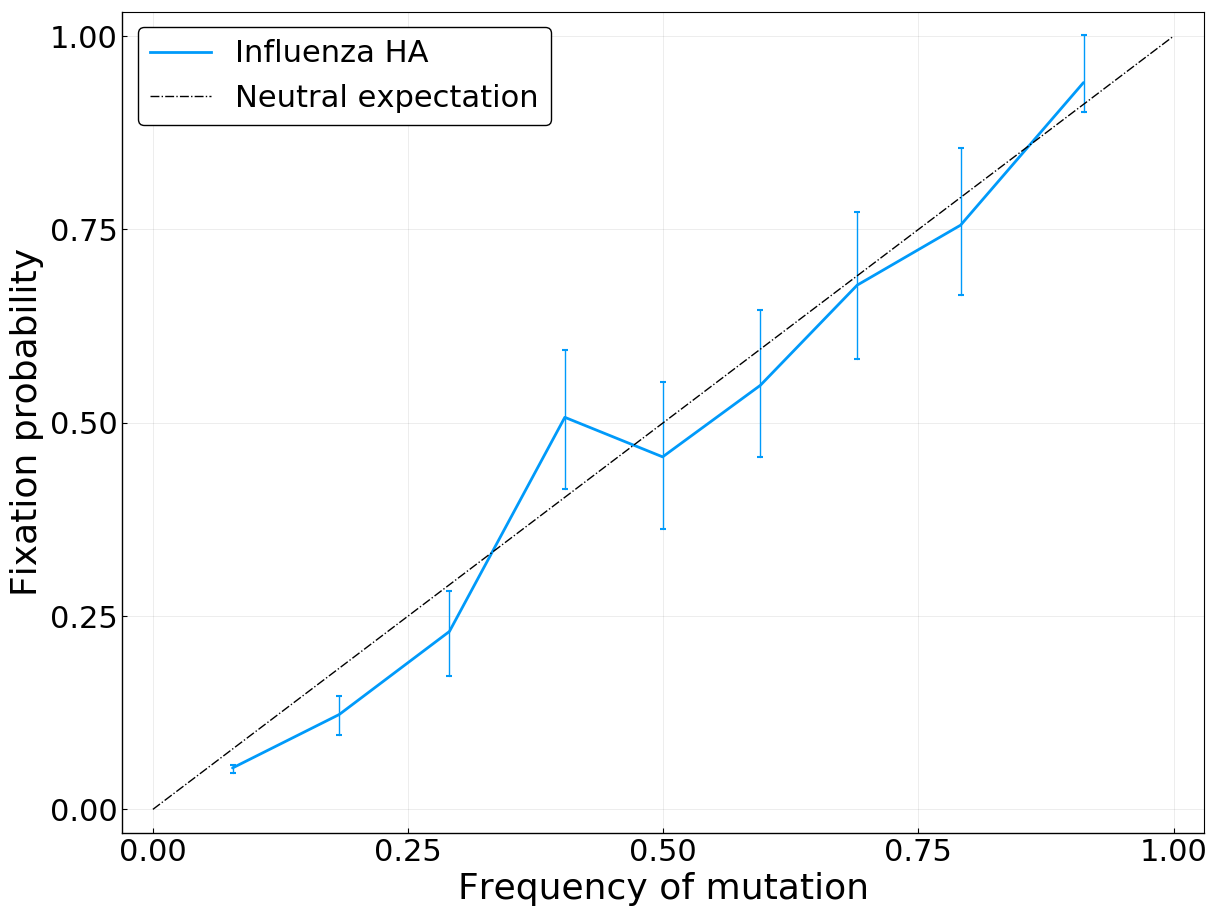

In [11]:
p = plot(size = (1200,900))
plot!(p, x, y, yerr=err, label="Influenza HA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_thirdcodonpos.png")

# NA 

In [12]:
na_aln = "../../data/aligned_h3n2_na_aa.fasta"
fp_na = Flu.FluPop(na_aln, :aa, Flu.flu_usual_header_fields, flulineage="h3n2", segment="na");
Flu.bin_by_date!(fp_na, start=startdate, binwidth=binwidth, binspacing=binspacing);

Reading ../../data/aligned_h3n2_na_aa.fasta...
Read 36300 strains out of 39312. Filtered 3012. Could not read 0


In [13]:
ph_na = Flu.PosEvo(fp_na);
x,y,err = pfix_v_freq(ph_na, alphabins);

In [14]:
sort(fp_na.datebin)

OrderedCollections.OrderedDict{Tuple{Date,Date},Array{Strain{AminoAcidAlphabet},1}} with 230 entries:
  (2000-01-01, 2000-01-31) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-01-31, 2000-03-01) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-03-01, 2000-03-31) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-03-31, 2000-04-30) => Strain{AminoAcidAlphabet}[]
  (2000-04-30, 2000-05-30) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-05-30, 2000-06-29) => Strain{AminoAcidAlphabet}[]
  (2000-06-29, 2000-07-29) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-07-29, 2000-08-28) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-08-28, 2000-09-27) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-09-27, 2000-10-27) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-10-27, 2000-11-26) => Strain{AminoAcidAlphabet}[Strain{AminoAcidAlphabe…
  (2000-11-26, 2000-12-26) => Strain{AminoAcidAlphabe

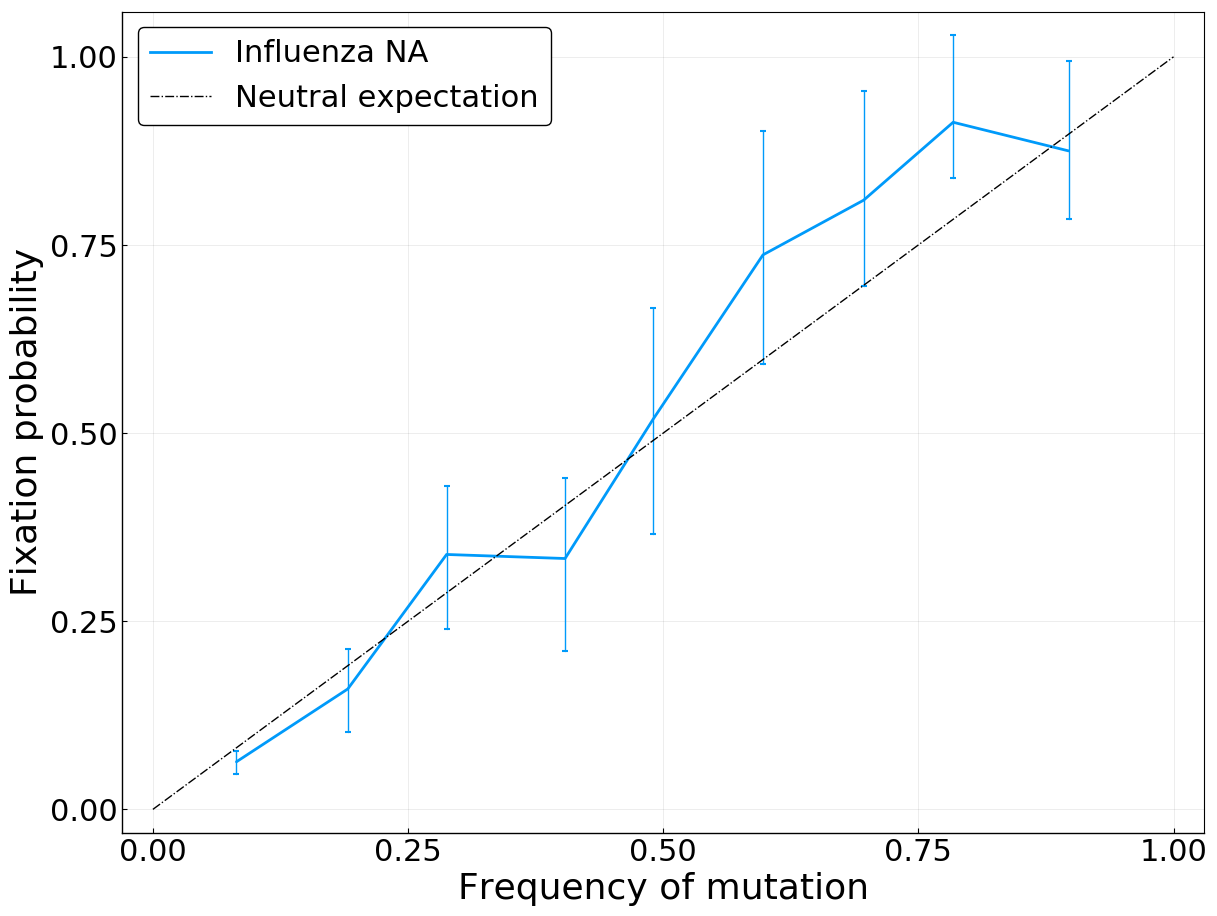

In [15]:
p = plot(size = (1200,900))
plot!(p, x, y, yerr=err, label="Influenza NA", line=(2))
plot!(p, [0,1],[0,1], label="Neutral expectation", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
savefig("$(plotfolder)/Pfix_v_freq_NA.png")

# Coalescence time

In [146]:
fp_all = Flu.FluPop("../../data/newtrees/100_per_4month/aligned_ha_aa.fasta", :aa, 
    Flu.flu_usual_header_fields);
# Flu.filter_by_region!(fp, ["north_america","europe"])
t = read_tree("../../data/newtrees/100_per_4month/results/tree_refined.nwk", NodeDataType=LBIData);
Flu.bin_by_date!(fp_all, start=Date(2000,4,1), binwidth=Day(182), binspacing=Day(182));
datebins = sort(collect(keys(fp_all.datebin)));

Reading ../../data/newtrees/100_per_4month/aligned_ha_aa.fasta...
Read 4379 strains out of 4402. Filtered 23. Could not read 0
  0.276541 seconds (1.13 M allocations: 131.979 MiB, 19.69% gc time)


In [193]:
divtimes = []
for db in datebins
    pop = fp.datebin[db]
    for i in 1:length(pop)
        for j in (i+1):length(pop)
#                 push!(divtimes, TreeTools.node_divtime(t.lleaves[pop[i][:strain]], 
#                                             t.lleaves[pop[j][:strain]])/2 / 0.004 * 365)
            a = lca(t.lleaves[pop[i][:strain]], t.lleaves[pop[j][:strain]])
            push!(divtimes, pop[i][:date] - Date(branchlengths[a.label]["date"]))
        end
    end
end

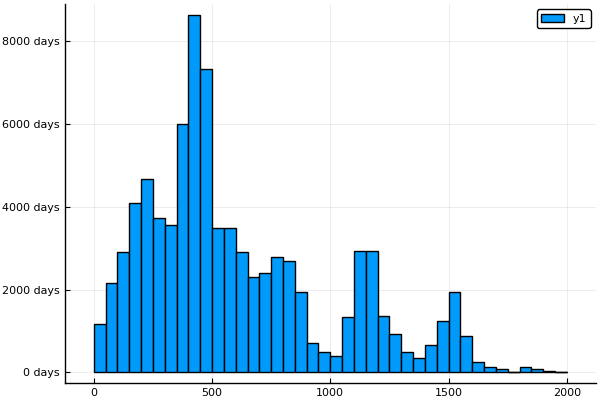

In [194]:
p = histogram(divtimes, bins = 0:50:2000)


## Distribution of coalescence times 
This is using strains of the *same* epidemic season, from NA and europe only. Same season means that pairs of strains were sampled the same year in the months of jan or feb. 

In [182]:
fp = Flu.FluPop("../../data/newtrees/100_per_4month/aligned_ha_aa.fasta", :aa, 
    Flu.flu_usual_header_fields);
Flu.filter_by_region!(fp, ["north_america","europe"])
t = read_tree("../../data/newtrees/100_per_4month/results/tree_refined.nwk", NodeDataType=LBIData);
Flu.bin_by_date!(fp, start=Date(2000,4,1), binwidth=Day(182), binspacing=Day(182));
datebins = sort(collect(keys(fp.datebin)));

Reading ../../data/newtrees/100_per_4month/aligned_ha_aa.fasta...
Read 4379 strains out of 4402. Filtered 23. Could not read 0
  0.514121 seconds (561.54 k allocations: 81.062 MiB, 72.49% gc time)


In [186]:
branchlengths = JSON.Parser.parsefile("../../data/newtrees/100_per_4month/results/branch_lengths.json");
branchlengths = branchlengths["nodes"];

In [270]:
divtimes = []
for db in datebins
    pop = fp.datebin[db]
    for i in 1:length(pop)
        for j in (i+1):length(pop)
            if in(month(pop[i][:date]), [1,2]) && in(month(pop[j][:date]), [1,2])
#                 push!(divtimes, TreeTools.node_divtime(t.lleaves[pop[i][:strain]], 
#                                             t.lleaves[pop[j][:strain]])/2 / 0.004 * 365)
                a = lca(t.lleaves[pop[i][:strain]], t.lleaves[pop[j][:strain]])
                push!(divtimes, pop[i][:date] - Date(branchlengths[a.label]["date"]))
            end
        end
    end
end

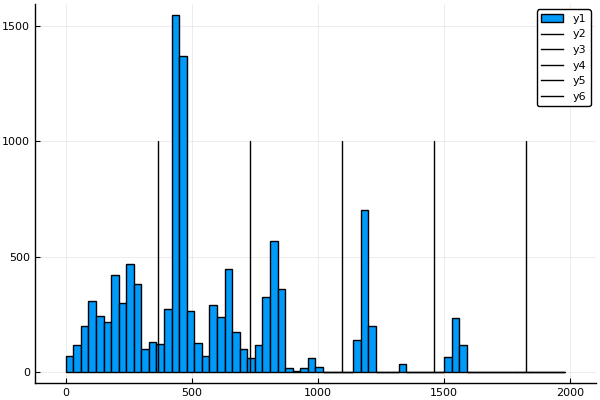

In [272]:
p = histogram([x.value for x in divtimes], bins = 0:30:2000)
for n in 1:5
    plot!([n, n]*365, [0,1000], line=(:black))
end
# plot!(0:10:2000, Nseq.(0:10:2000))
p

In [264]:
h = fit(Histogram, sampleT(length(divtimes)), 0:30:2000);

In [266]:
h.edges

(0:30:1980,)

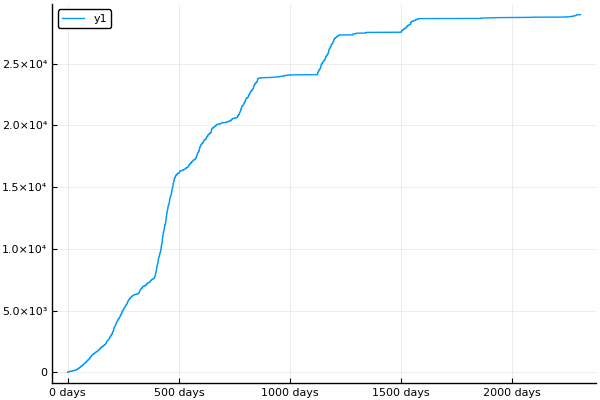

In [233]:
plot(sort(divtimes), 1:length(divtimes))

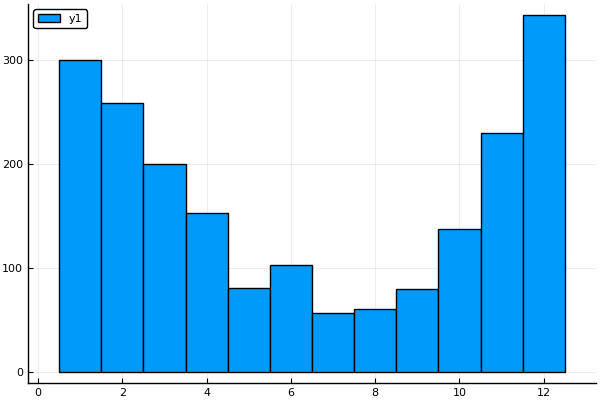

In [226]:
histogram([month(s[:date]) for s in values(fp.strains)], bins=0.5:1:12.5)

In [219]:
h = fit(Histogram, [month(s[:date]) for s in values(fp.strains)], 0.5:1.:12.5);
# idx = vcat(6:12, 1:5)
# scatter(1:12, [h.weights[i] for i in idx])

In [229]:
function Nseq(t)
    return (h.weights[month(Date(2010,01,31) - Day(t))])
end

Nseq (generic function with 1 method)

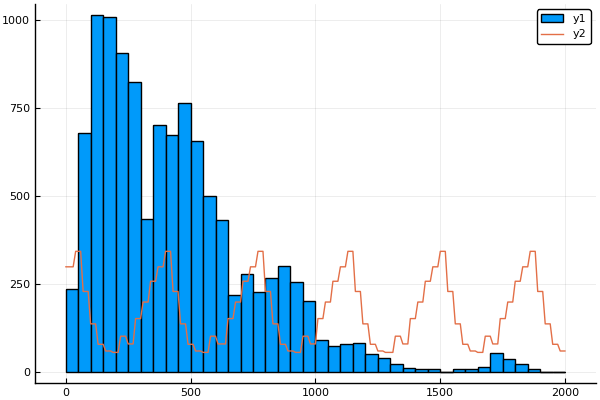

In [155]:
p = histogram(divtimes, bins = 0:50:2000)
plot!(0:10:2000, Nseq.(0:10:2000))

In [248]:
global N0 = 1000
N(t, α = 0.9, ω = 1. /365) = N0 * (1 + α*cos(2*3.14*ω*t));
N(t, α = 0.9, ω = 1. /365) = Nseq(t) * 5

function sampleT(α=0.9, ω=1. /365)
    c = false
    t = 1
    while !c
        if rand() < 1. /(N(t,α,ω) -1)
            c = true
        end
        t += 1
    end
    return t
end
function sampleT(n::Int64, α=0.9, ω=1. /365)
    out = Array{Int64,1}(undef, n)
    for i in 1:n
        out[i] = sampleT(α,ω)
    end
    return out
end

sampleT (generic function with 7 methods)

In [246]:
ts = sampleT(10000, 0.5);

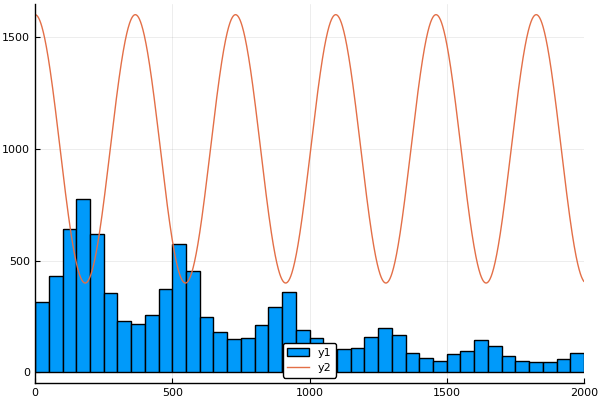

In [247]:
p = histogram(ts, xlim=(-1,2000), bins = 0:50:2000)
plot!(0:1:2000, N.(0:1:2000, 0.6))
# for n in 1:5
#     plot!(p, [n, n]*365, [0,1000], line=(:black), label="")
# end
# p

In [159]:
N(1)

1899.8667904507722

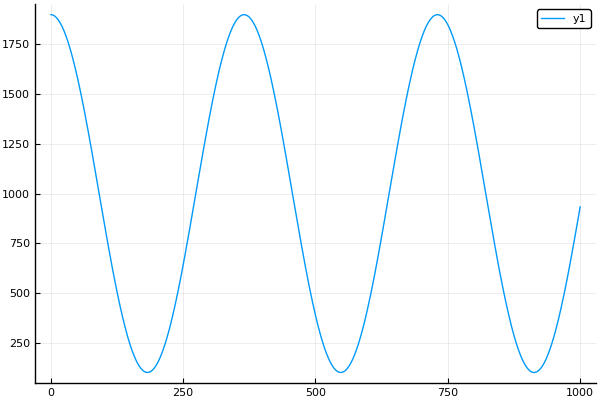

In [160]:
plot(0:1000, N.(0:1000))